In [2]:
from keras.applications import VGG16

In [3]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [5]:
base_dir = 'cats_and_dogs'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [6]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [7]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))

    generator = datagen.flow_from_directory(directory, 
                                            target_size=(150, 150), 
                                            batch_size=batch_size, 
                                            class_mode='binary')

    i = 0
    for input_batch, label_batch in generator:
        feature_batch = conv_base.predict(input_batch)
        features[i*batch_size : (i+1)*batch_size] = feature_batch
        labels[i*batch_size : (i+1)*batch_size] = label_batch

        i += 1
        if i * batch_size >= sample_count:
            break
            
    return features, labels

In [12]:
train_features, train_labels = extract_features(train_dir, 2000)

Found 2000 images belonging to 2 classes.


C:\Users\bin b zhu\AppData\Local\Continuum\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\bin b zhu\AppData\Local\Continuum\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\bin b zhu\AppData\Local\Continuum\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 4951. Skipping tag 51
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\bin b zhu\AppData\Local\Continuum\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293339136 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(

In [16]:
np.save('{}/train_features'.format(base_dir), train_features)
np.save('{}/train_labels'.format(base_dir), train_labels)

In [11]:
train_features = np.load('{}/train_features.npy'.format(base_dir))
train_labels = np.load('{}/train_labels.npy'.format(base_dir))

In [14]:
train_labels.shape

(2000,)

In [16]:
val_features, val_labels = extract_features(validation_dir, 1000)

Found 1000 images belonging to 2 classes.


C:\Users\bin b zhu\AppData\Local\Continuum\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\bin b zhu\AppData\Local\Continuum\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\bin b zhu\AppData\Local\Continuum\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\bin b zhu\AppData\Local\Continuum\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data)

In [17]:
np.save('{}/validation_features'.format(base_dir), val_features)
np.save('{}/validation_labels'.format(base_dir), val_labels)

In [ ]:
val_features = np.load('{}/validation_features.npy'.format(base_dir))
val_labels = np.load('{}/validation_labels.npy'.format(base_dir))

In [18]:
test_features, test_labels = extract_features(test_dir, 1000)

Found 1000 images belonging to 2 classes.


In [19]:
np.save('{}/test_features'.format(base_dir), test_features)
np.save('{}/test_labels'.format(base_dir), test_labels)

In [ ]:
test_features = np.load('{}/test_features.npy'.format(base_dir))
test_labels = np.load('{}/test_labels.npy'.format(base_dir))

In [20]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
val_features = np.reshape(val_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [21]:
from keras import models, layers, optimizers

In [22]:
network = models.Sequential()

In [23]:
network.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(1, activation='sigmoid'))

In [24]:
network.compile(loss='binary_crossentropy', 
                optimizer=optimizers.RMSprop(lr=2e-5), 
                metrics=['acc'])

In [25]:
history = network.fit(train_features, train_labels, epochs=30, batch_size=20, 
                      validation_data=(val_features, val_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6231 - acc: 0.6500 - val_loss: 0.4408 - val_acc: 0.8360
Epoch 2/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4349 - acc: 0.8000 - val_loss: 0.3586 - val_acc: 0.8630
Epoch 3/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3736 - acc: 0.8360 - val_loss: 0.3260 - val_acc: 0.8690
Epoch 4/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3150 - acc: 0.8685 - val_loss: 0.2981 - val_acc: 0.8770
Epoch 5/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2777 - acc: 0.8855 - val_loss: 0.2825 - val_acc: 0.8810
Epoch 6/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2578 - acc: 0.8970 - val_loss: 0.2764 - val_acc: 0.8900
Epoch 7/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2456 - acc: 0.9000 - val_loss: 0.2629 - val_acc: 0.8850
Epoch 8/30
200

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [29]:
epochs = range(1, len(acc)+1)

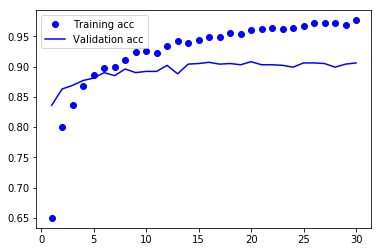

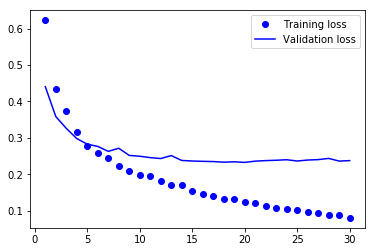

In [30]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()
plt.show()